# Inspecting the Phynet-Data

In [1]:
# Importing the needed libraries

# Comunication with the operating system
import os

# Using regular expressions
import re

# Computing numerical data (standard for numbers, vectors, high dimensional arrays)
import numpy as np

# Provides a structure to store and manipulate data/spreadsheets
import pandas as pd

# Library to create plots
import matplotlib.pyplot as plt

In [2]:
# Path to the folder containing the csv-files; can be an absolute or relative path
folder_data = 'Data2Learn'

# Creates a list with the paths for all csv-files
path_files = [ os.path.join( folder_data, file ) for file in os.listdir( folder_data )]

# Print the number of files
print( 'Number of files: {}'.format( len( path_files )))

Number of files: 44


In [3]:
# Empty list to store the data
data = []

# Iterate over each csv-file-path
for i, file in enumerate( path_files ):
    # try loading the data, print if loading is impossible; will not terminate the program
    try:
        # Open the file and store the data in a DataFrame (pandas data structure/spreadsheet)
        df = pd.read_csv( file )
        # Add a new column to the DataFrame; the value is the number in the file-name
        df['Light'] = int( re.search( 'B(.*)Data', file )[1])
        # Append the DataFrame to the empty list
        data.append( df )
    except:
        # If there is an error while loading, print 'Error ...' and proceed the for-loop
        print( 'Error: {} {}'.format( i, file ))
        
# The list 'data' contains a DataFrame for each file; join the DataFrames to a single DataFrame
df = pd.concat( data )

Error: 28 Data2Learn/Merged_B75Data20Sep2017151550.csv


In [4]:
# Show the first 5 rows of the DataFrame
df.head()

,Time,UNIX_T,RSSI1,RSSI2,RSSI3,Lux,Acc_x,Acc_y,Acc_z,Temp,ID,Pos,Si,Co,Ro,Light
0,2017-09-22 14:38:15.443,1506083895443,52,66,61,5,-1110,-22,93,2223,1,231,2,3,1,50
1,2017-09-22 14:38:15.497,1506083895497,48,53,66,8,-1035,6,86,2181,2,152,1,5,2,50
2,2017-09-22 14:38:15.546,1506083895546,53,62,50,8,-1091,-54,133,2107,3,111,1,1,1,50
3,2017-09-22 14:38:15.597,1506083895597,55,75,42,3,-1074,4,106,2093,4,223,2,2,3,50
4,2017-09-22 14:38:15.646,1506083895646,57,56,63,4,-1054,-43,108,28587,5,252,2,5,2,50


In [5]:
# Show the shape; 42415 rows, 16 columns
df.shape

(42415, 16)

/home/jm/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


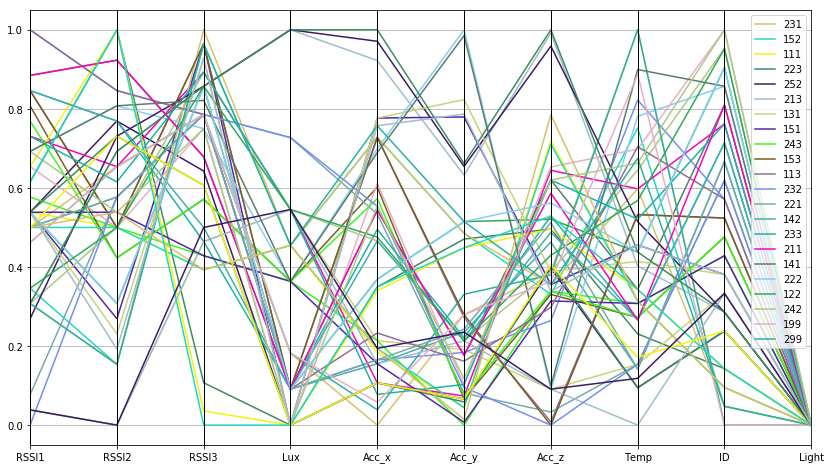

In [6]:
# Import a function to normalize the data
from sklearn import preprocessing

# Create a smaller second DataFrame, by dropping unnecessary columns
df_plot = df.drop( [ 'Time', 'Pos', 'Si', 'Co', 'Ro', 'UNIX_T' ], axis=1 )

# Store the column-names of the new DataFrame
col = df_plot.columns

# Cleaning the data
# Use only those rows, where the 'Temp' is higher than -10000 and lower than 10000
df_plot = df_plot[ ( df_plot[ 'Temp' ] >- 10000 ) & ( df_plot[ 'Temp' ] < 10000 )]


# Just use 50 examples/rows
n = 50

# Get the values of the first 50 rows
x = df_plot.values[ :n ]

# Preparation to scale eaach row
min_max_scaler = preprocessing.MinMaxScaler()
# Scale each row to the range 0-1
x_scaled = min_max_scaler.fit_transform( x )

# Create a DataFrame containing the scaled dataset and set the columnm-names
df_plot = pd.DataFrame( x_scaled, columns=col )
# Add a column with the labels to the DataFrame
df_plot[ 'Pos' ] = df[ 'Pos' ].values[ :n ]

# Import the function to plot the DataFrame
from pandas.plotting import parallel_coordinates

# Set the size of the plot
plt.figure( figsize=( 14, 8 ))
# Plot the data; color the lines by the column 'Pos'
parallel_coordinates( df_plot, 'Pos' )
# Show the plot
plt.show()

The x axis represents all variables. By looking at the line-colors maybe a separation can be seen in one variable.

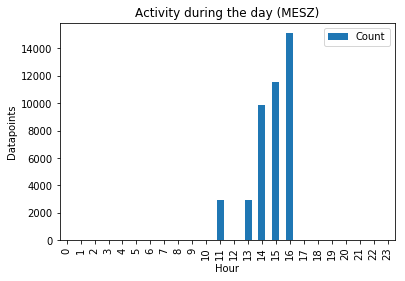

In [7]:
# Convert the 'Time'-column to a datetime-type
df['Time'] = pd.to_datetime(df['Time'])
# Create a new DataFrame grouped by hour and count the values for each hour
df_time = df['Time'].groupby(pd.DatetimeIndex(df.Time).hour).count().to_frame().rename(columns={'Time':'Count'})

# Not every hour contains data
# Add inactive hours
for time in [i for i in range(0, 24)]:
    if time not in df_time.index.tolist():
        df_time.loc[time] = 0
# Sort the indices
df_time = df_time.sort_index()

# Plot a Bar-Chart
df_time.plot(kind='bar')
plt.title('Activity during the day (MESZ)')
plt.xlabel('Hour')
plt.ylabel('Datapoints')
plt.show()

Error: Time


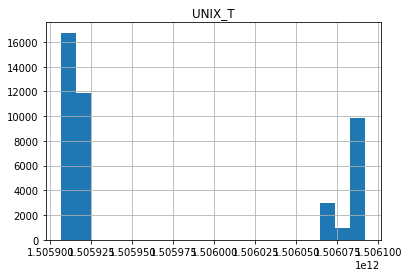

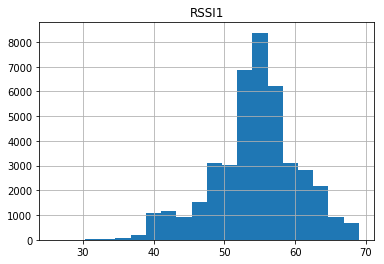

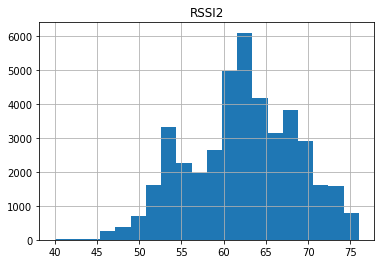

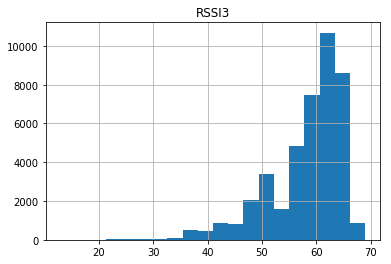

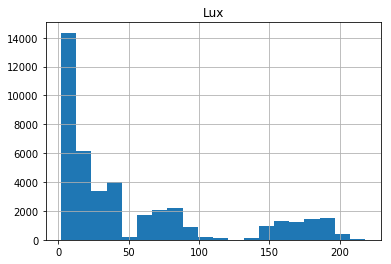

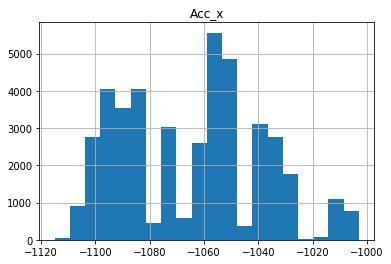

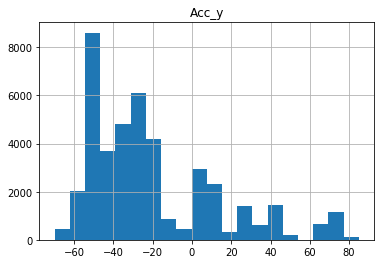

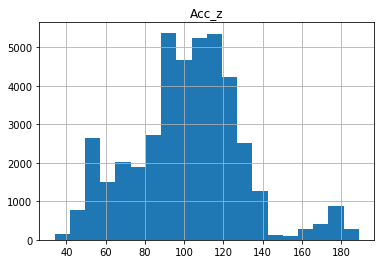

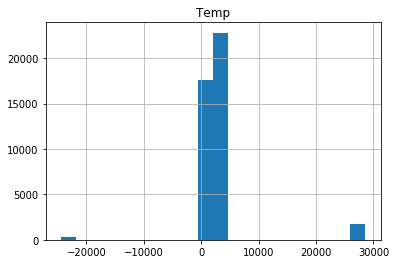

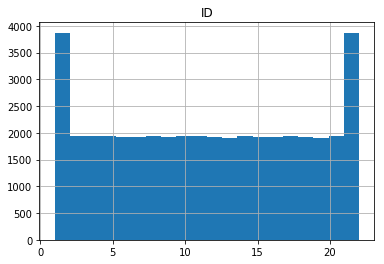

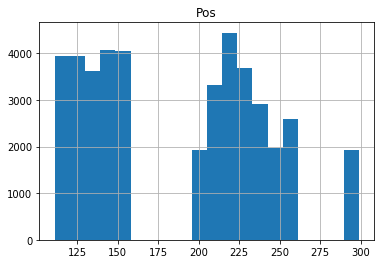

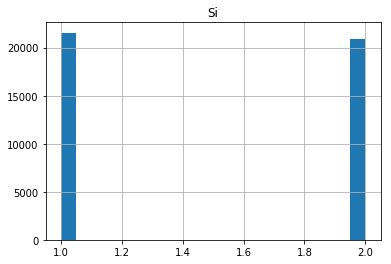

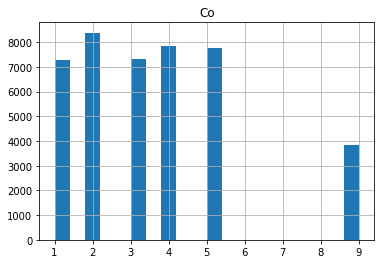

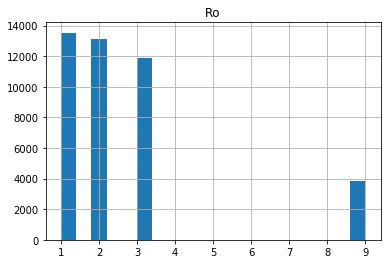

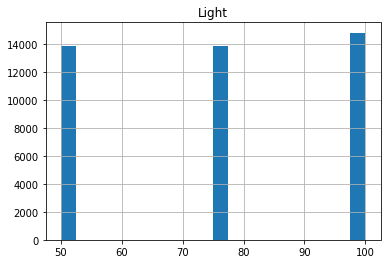

In [8]:
# Create a histogram for eaach columns
for col in df.columns:
    # If a histogram is impossible, print 'Error'
    try:
        df.hist(col, bins=20)
        plt.title(col)
        plt.show()
    except:
        print('Error: {}'.format(col))

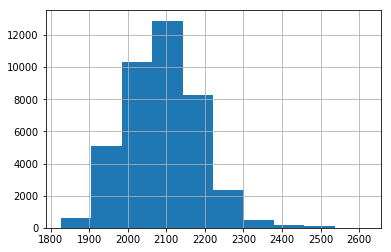

In [9]:
# Create a histogram by using only a small fraction of the 'Temp'-data
df[(df['Temp']>-10000) & (df['Temp']<10000)]['Temp'].hist()
plt.show()

In [10]:
# Count the values for every label-'Pos'
pos = df['Pos'].value_counts()
pos.sort_values()

133     718
243     853
253     942
232     987
212     988
121    1074
112    1111
143    1120
221    1122
152    1124
251    1124
213    1125
233    1208
142    1210
211    1212
111    1343
241    1384
123    1390
153    1391
132    1394
231    1481
122    1481
113    1483
131    1518
242    1526
151    1528
252    1658
223    1658
222    1661
141    1745
199    1923
299    1933
Name: Pos, dtype: int64

# Train a DecisionTree-Model - Code copied from the internet

In [11]:
# Import
from sklearn import tree

# List to store the accuracy values
accs = []
# Iterate over 10 Trees
for _ in range(10):
    # Permuate the DataFrame
    df = df.sample(frac=1).reset_index(drop=True)
    
    # Use only 40000 rows
    train_events = 40000
    # Use only the column 'Temp'
    used_columns = ['Temp']

    # Get the data-values of the 40000 rows
    X = df[used_columns].values[:train_events]   
    # Get the label-values of the 40000 rows
    Y = df['Pos'].values[:train_events]
    # Create a DecisionTree
    clf = tree.DecisionTreeClassifier(max_depth=10)
    # Train the Tree
    clf = clf.fit(X, Y)

    # Create a testing dataset with the remaining rows
    X = df[used_columns].values[train_events:]
    Y = df['Pos'].values[train_events:]
    # Predict labels for the test-dataset
    Y_pred = clf.predict(X)

    # Import a function to compute the accuracy
    from sklearn.metrics import accuracy_score
    # Compute the accuracy and append it to the empty list
    accuracy = accuracy_score(Y, Y_pred)
    accs.append(accuracy)

# Plot the mean and std of the 10 trees
print('Accuracy - Mean: {} Std: {}'.format(np.mean(accs), np.std(accs)))

Accuracy - Mean: 0.2705590062111801 Std: 0.007248624318719325


# Train a RandomForest-Model and compare the feature importances - Code copied from the internet

Feature ranking:
1. feature RSSI2 (0.196923)
2. feature RSSI3 (0.172063)
3. feature RSSI1 (0.158640)
4. feature ID (0.131424)
5. feature Temp (0.094943)
6. feature Acc_y (0.072075)
7. feature Acc_z (0.055171)
8. feature Acc_x (0.054904)
9. feature Lux (0.054804)
10. feature Light (0.009053)


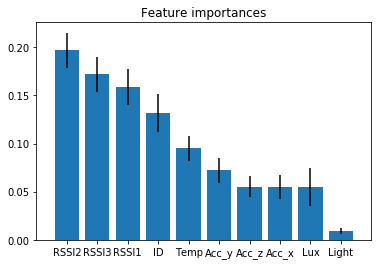

In [12]:
# Import
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Get the data and labels
used_columns = ['Temp', 'RSSI1', 'RSSI2', 'RSSI3', 'Lux', 'Light', 'ID', 'Acc_x', 'Acc_y', 'Acc_z']
X = df[used_columns].values
y = df['Pos'].values

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

# Train the forest
forest.fit(X, y)
# Get the feature importances form the forest
importances = forest.feature_importances_
# Compute the std of the importances
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
# Get the indices and the label-names
indices = np.argsort(importances)[::-1]
labels=[used_columns[i] for i in indices]

print("Feature ranking:")

# Print the importances
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))


# Create a plot containing the importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), labels)
plt.xlim([-1, X.shape[1]])
plt.show()

In [13]:
# Store the DataFrame containing all files in a single file
df.to_csv('PhynetLab.csv', index=False)